# Data Retrieval

In [18]:
import pandas as pd
from astroquery.utils.tap.core import TapPlus
import sys
import os
sys.path.append(os.path.abspath("src"))
from module import *

#check if ZooSpecPhotoDR19_filtered.csv exists
if not os.path.exists("ZooSpecPhotoDR19.csv.gz"):
    print("ZooSpecPhotoDR19.csv.gz not found. Downloading data from TAP service...")
    # Connect to the TAP service (from TOPCAT)
    tap = TapPlus(url="http://tap.roe.ac.uk/ssa")

    # ADQL query
    adql = """
    SELECT TOP 20000
            z.*,
            p.*
    FROM BestDR9.ZooSpec AS z
    JOIN BestDR7.PhotoObj AS p
        ON p.objid = z.dr7objid
    """

    # Run synchronously
    job = tap.launch_job(adql)
    results = job.get_results()
    df = results.to_pandas()
    print(df.shape)

else:
    print("ZooSpecPhotoDR19.csv.gz found. Loading data from file...")
    df = pd.read_csv("ZooSpecPhotoDR19.csv.gz", compression='gzip')
    print(df.shape)

# Safely convert numeric columns
df = df.apply(safe_to_numeric).set_index("dr7objid")


ZooSpecPhotoDR19.csv.gz found. Loading data from file...
(659272, 90)


# Data Filtering

In [19]:
mask = (
# correct magnitudes
(df["modelMag_u"] > -30)
& (df["modelMag_g"] > -30)
& (df["modelMag_r"] > -30)
& (df["modelMag_i"] > -30)
& (df["modelMag_z"] > -30)
&
# reasonable errors
(df["modelMagErr_u"] < 0.5)
& (df["modelMagErr_g"] < 0.05)
& (df["modelMagErr_r"] < 0.05)
& (df["modelMagErr_i"] < 0.05)
& (df["modelMagErr_z"] < 0.1)
&
# very certain about the classification
((df["p_cs_debiased"] >= 0.9) | (df["p_el_debiased"] >= 0.9))
&
# medium size
(df["petroR90_r"] * 2 * 1.5 / 0.4 < 64)
& (df["petroR90_r"] * 2 / 0.4 > 20)
)
cols_to_keep = (
[
"specobjid",
"objid",
"ra",
"dec",
"p_el_debiased",
"p_cs_debiased",
"spiral",
"elliptical",
]
+ ["petroR50_r", "petroR90_r"]
+ [f"modelMag_{f}" for f in "ugriz"]
+ [f"extinction_{f}" for f in "ugriz"]
)
df_filtered = df[mask][cols_to_keep]
#df_filtered = df_filtered.sample(10000,random_state=32)
df_filtered.head()
df_filtered.to_csv("ZooSpecPhotoDR19_filtered.csv.gz", compression='gzip')
print(df_filtered.shape)
del df_filtered
del df

(69352, 20)


# Image download

In [20]:
import matplotlib.pyplot as plt
import requests
import tarfile
import io
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image

In [21]:
#Read CSV

df = pd.read_csv("ZooSpecPhotoDR19_filtered.csv.gz", compression='gzip') 
if len(df) > 10_000:
    df = df.sample(10_000, random_state=42) #To have always the same sample
print(df.shape)


(10000, 21)


In [22]:
#Let's work with Hips2Fits

HIPS_URL = "https://alasky.cds.unistra.fr/hips-image-services/hips2fits"

#We need to access the Hips2Fits URL and look for what we want. We will need a function for that.
#Compulsory input parameters: hips, width, height, projection, fov, ra, dec.

In [23]:
#Once we know where to look for, it is time for the storage part

Output_Dir = Path("Images") #Output directory, name of the folder we are shaving everything
Output_Dir.mkdir(exist_ok=True) #Making the directory, and in case it exist, an error won't appear

#The 'problem' here is that we have MORE than 60k images. We will use TAR files to save them. The reason is simple:
#we can save thousands of images in one TAR file, and it will count as just one object instead of thousands.
#Even though it might be tougher to grab just one image, when talking about storing and transferring datasets
#it is way more efficient.


if (not os.path.exists(Output_Dir/"Images_downloaded.csv.gz")):
    print("Images not found. Downloading images...")
else:
    #df_metadata = pd.read_csv("output/images_downloaded.csv.gz", compression='gzip')
    df_downloaded = pd.read_csv(Output_Dir / "Images_downloaded.csv.gz", compression='gzip')
    #We remove from df the objid that are already in df_downloaded
    df = df[~df['objid'].isin(df_downloaded['objid'])].copy() #We use copy to avoid SettingWithCopyWarning later
    #We reset the index
    df = df.reset_index(drop=True)
    print("Images to download: ", df.shape[0])


Images_per_TAR = 1000

Images_metadata= [] #Metadata about the downloaded images will be saved here

#We create an empty list at the beginning. Each added element is a triplet (3-tuple) of three elements:
# - Filename: the desired name of the image inside the TAR.
# - Bytes: real binary data of the image downloaded with "requests" (better explained later)
# - Extra: we want to associate the data we have in the CSV to our images.

Images_buffer = []  # [(filename, bytes, extra), ...]
TAR_index = 0 #To count from the beginning

Images to download:  10000


In [24]:
#When using parallelization we need to control the amount of attempts per image, retry in case of error and quit
#after several failed attempts so we don't get stucked.

#When accessing Hits2Fits, as we have a lot of requests, we won't be doing it one by one. For that, we need to keep a 'session' open
#all the time. It will save up time. How do we do that? With Python’s standard library "requests" for HTTP requests.

session = requests.Session() #Creates a persistent session object that maintains certain things between requests:
                            #  - Persistent TCP connection to avoid repeated handshake for each image.
                            #  - Cookies to be reused automatically if the server uses them for authentication.

In [25]:
#Parallel execution

#As we don't want to be working TAR by TAR, we can parallelize. Parallelization is the process of running multiple tasks
#simultaneously instead of sequentially.

with ThreadPoolExecutor(max_workers=20) as executor: #Up to 20 images downloaded at the same time.
    
    #Let's write a list of parallel tasks (in our case, image downloading). We have to use a dictionary to avoid errors:
    futures = {executor.submit(download_with_retries, t.ra, t.dec, t.petroR90_r): t
    for t in df.itertuples()}
    
    Images_downloaded = [] #We create an empty list to save the metadata of the images in the CSV file.
    #itertuples() reiterate in every row of the DataFrame. Each row is converted in a namedtuple,
    #which means that we have access to the columns by name or position.

    completed = 0 #We start the counter
    
    for f in as_completed(futures): #as_completed(futures) is an iterator that returns the 'futures' (our lists) as they finish.
        Images_metadata = futures[f]
        bits = f.result() 
        if bits is not None:
            filename = str(Images_metadata.objid)
            extra = {
                "objid": Images_metadata.objid,
                "ra": Images_metadata.ra,
                "dec": Images_metadata.dec,
                "spiral": getattr(Images_metadata, "spiral", None),
                "elliptical": getattr(Images_metadata, "elliptical", None),
            }
            Images_buffer.append((filename,bits,extra))
            Images_downloaded.append(Images_metadata.objid) #We add the metadata of the image to the list we will use for the CSV file.            
        else:
            continue #We don't want everything to stop
        completed += 1

        if completed % 1000 == 0: #completed % 100 calculates the remainder of that division. In other words: if it's 100% completed.
            print("We got this!") #is not necesary, but it is nice to see the progress.

        if len(Images_buffer) >= Images_per_TAR: #If the TAR is full
            save_images_to_TAR(Output_Dir / f"TAR-{TAR_index:06d}.tar", Images_buffer) # creates the TAR file on your disk
            Images_buffer = [] #We empty it so we can start filling again
            TAR_index += 1 # So the following TAR gets the next number

#We write last shard if not empty
if Images_buffer: #Checks if the list is not empty.
    save_images_to_TAR(Output_Dir/ f"TAR-{TAR_index:06d}.tar", Images_buffer)

We got this!
TAR saved in: Images/TAR-000000.tar
We got this!
TAR saved in: Images/TAR-000001.tar
We got this!
TAR saved in: Images/TAR-000002.tar
We got this!
TAR saved in: Images/TAR-000003.tar
We got this!
TAR saved in: Images/TAR-000004.tar
We got this!
TAR saved in: Images/TAR-000005.tar
We got this!
TAR saved in: Images/TAR-000006.tar
We got this!
TAR saved in: Images/TAR-000007.tar
We got this!
TAR saved in: Images/TAR-000008.tar
We got this!
TAR saved in: Images/TAR-000009.tar


In [26]:
#We have finished with the downloads. Now let's save the metadata we got as a compressed CSV

Images_downloaded = pd.DataFrame(Images_downloaded, columns=["objid"])

#Making the directory, and in case it exist, an error won't appear
Output_Dir.mkdir(parents=True, exist_ok=True) #The command parents=True creates all the missing parent directories in the path.

Images_downloaded.to_csv(Output_Dir / "Images_downloaded.csv.gz", index=False, compression="gzip")

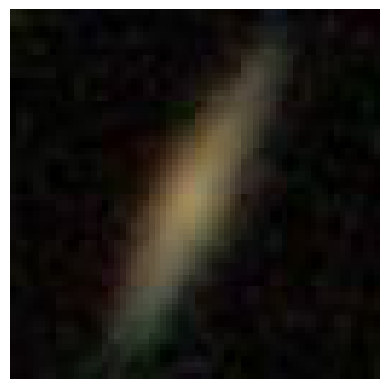

In [27]:
#Let's see if we can plot any image

#We are openning the first TAR (for example)
tar_path = "Images/TAR-000000.tar"
with tarfile.open(tar_path, "r") as tar:
    # list contents
    members = tar.getmembers()
    # extract the first cutout
    img_member = members[0]
    img_bytes = tar.extractfile(img_member).read()

# show the image
img = Image.open(io.BytesIO(img_bytes)) 
plt.imshow(img)
plt.axis("off")
plt.show()

# Pixel-based PCA for image compression

In [28]:
import numpy as np
from PIL import Image
from io import BytesIO
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

In [29]:
tar_folder = "Images"          #Folder with the TAR files
tar_files = [os.path.join(tar_folder, f) for f in os.listdir(tar_folder) if f.endswith('.tar')] #List of TAR files
pca_output = "Images_PCA.parquet"  #Final file with PCA
n_components = 100                   #PCA number of components. More number, less compression, better quality
batch_size = 1000                     #Set of images to process in memory

scaler = StandardScaler() #PCA depends on variance: if there is one characteristic with bigger values,
                          #it would dominate. In order to prevent that, we scalate so everything would contribute the same

ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size) #Inicializes an incremental PCA.
# It allows processing large volumes of data in batches, without loading everything into memory at once.

In [30]:
#FIRST PASS of preprocessing before applying PCA: Calculate the mean and global standard devitation of all pixels

X_batch = [] #Creates an empty list to temporarily store pixel vectors for each batch.
for tar_path in tar_files:
    with tarfile.open(tar_path, "r") as tar:
        members = [m for m in tar.getmembers() if m.name.lower().endswith(".jpg")] #Filters only the .jpg images inside the archive.
        for member in members:
            f = tar.extractfile(member) #Extracts the current image file as a binary object in memory.
            if f is not None: #Checking if the image is successfully extracted.
                try:
                    img = Image.open(BytesIO(f.read())).convert("RGB").resize((64, 64)) #Reads the image bytes into memory, opens it,
                                                                                        #ensures 3 color channels and resizes to a fixed shape
                    pixels = np.array(img).astype(np.float32).flatten() / 255.0 #Converts the image into a NumPy array, flattens it from
                                                                                #64×64×3=12288-length vector and normalizes pixel values to
                                                                                # the range [0, 1].
                                                                                #It makes values float32 (needed by scaler/IPCA).
                    X_batch.append(pixels) #Adds the pixel vector to the current batch.
                    
                    if len(X_batch) >= batch_size:
                        scaler.partial_fit(np.array(X_batch))  #When the batch is full, scaler.partial_fit() updates the mean and standard
                                                                #deviation for scaling using just that batch.

                        X_batch = [] #It clears X_batch to start collecting a new batch.
                except Exception as e:
                    print(f"Error reading {member.name}: {e}")

#Processing the last set
if X_batch:
    scaler.partial_fit(np.array(X_batch))
    X_batch = []

In [31]:
#SECOND PASS adjusting incremental PCA in sets: scalates all the data and trains IncrementalPCA

X_batch = []
for tar_path in tar_files:
    with tarfile.open(tar_path, "r") as tar:
        members = [m for m in tar.getmembers() if m.name.lower().endswith(".jpg")]
        for member in members:
            f = tar.extractfile(member)
            if f is not None:
                try:
                    img = Image.open(BytesIO(f.read())).convert("RGB").resize((64, 64))
                    pixels = np.array(img).astype(np.float32).flatten() / 255.0
                    X_batch.append(pixels)
                    
                    if len(X_batch) >= batch_size:
                        X_scaled = scaler.transform(np.array(X_batch)) #Convert the list to a NumPy array of shape
                                                                       #(n_samples_in_batch, n_features) and standardize it using the
                                                                       #scaler fitted during the first pass. This centers each feature
                                                                       #to mean 0 and scales to unit variance
                                                                       #(using global mean/std learned earlier).
                        ipca.partial_fit(X_scaled) #Feed the standardized batch to the IncrementalPCA. partial_fit() updates the PCA internal
                                                   #state (estimates of components, means...) incrementally. Each call refines the global PCA
                                                   #using the new batch.
                        X_batch = []
                except:
                    pass

print(len(X_batch))

#Last set
if X_batch:
    X_scaled = scaler.transform(np.array(X_batch))
    ipca.partial_fit(X_scaled)
    X_batch = []

0


These two codes can't merge (even if they seem to be very similar)

When using "StandardScaler", it needs to know the global mean and global standard deviation of the entire dataset
in order to scale the data correctly. The problem is that during the first pass, those statistics are not yet known.
They are still being computed gradually. If "scaler.transform()" is applied at the same time as "scaler.partial_fit()",
you would be scaling using partial and changing values, not the final mean and standard deviation.
This would cause each batch to be scaled differently and if the data aren’t scaled consistently, the PCA would learn
distorted or incorrect components.

In [32]:
#THIRD PASS transforming and saving PCA

all_filenames = []
all_pca = []
X_batch = []

for tar_path in tar_files:
    with tarfile.open(tar_path, "r") as tar:
        members = [m for m in tar.getmembers() if m.name.lower().endswith(".jpg")]
        for member in members:
            f = tar.extractfile(member)
            if f is not None:
                try:
                    img = Image.open(BytesIO(f.read())).convert("RGB").resize((64, 64))
                    pixels = np.array(img).astype(np.float32).flatten() / 255.0
                    X_batch.append(pixels)
                    #Clean name: just base name without extention
                    clean_name = os.path.splitext(os.path.basename(member.name))[0] #Create a “clean” identifier
                                                                                    #(filename without directory or extension) for the image.
                    all_filenames.append(clean_name) #Append that clean name to the global filename list immediately
                    
                    if len(X_batch) >= batch_size:
                        X_scaled = scaler.transform(np.array(X_batch)) #Use the already-fitted StandardScaler (from FIRST PASS)
                                                                       #to standardize the batch.
                        pcs = ipca.transform(X_scaled) #Use the already-fitted IncrementalPCA (from SECOND PASS) to project
                                                       #the standardized batch into PCA
                        all_pca.append(pcs)
                        X_batch = []
                except:
                    pass

#Last set
if X_batch:
    X_scaled = scaler.transform(np.array(X_batch))
    pcs = ipca.transform(X_scaled)
    all_pca.append(pcs)

In [33]:
#Merging all the sets
X_pca = np.vstack(all_pca)
pca_columns = [f"PC{i+1}" for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca.insert(0, "filename", all_filenames)

In [34]:
# Save final PCA
df_pca.to_parquet(pca_output, index=False)

In [35]:
#Read CSV and PCA
df_catalog = pd.read_csv("ZooSpecPhotoDR19_filtered.csv.gz", compression='gzip')
df_pca = pd.read_parquet("Images_PCA.parquet")

#Convert both to string so we can compare the 'objid' columns with the names of the images (saved as filename in the PCA)
df_catalog["objid"] = df_catalog["objid"].astype(str)
df_pca["filename"] = df_pca["filename"].astype(str)

# Merge
df_final = pd.merge(df_catalog, df_pca, left_on="objid", right_on="filename", how="inner")

#Eliminate the 'filename' column (duplicated)
df_final = df_final.drop(columns=["filename"])

#Save combinated dataset
df_final.to_parquet("Dataset_combinado.parquet", index=False)

# ML to create a galaxy morphology classifier

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# MORPHOLOGY CLASSIFIER

# Load the dataset

df = pd.read_parquet("Dataset_combinado.parquet")

# Define classifier as 1 for spiral, 0 for elliptical
df["morphology"] = df["spiral"].apply(lambda x: "Spiral" if x == 1 else "Elliptical")

# Choose whichever has higher probability
df["morphology"] = df.apply(
    lambda row: "Spiral" if row["spiral"] > row["elliptical"] else "Elliptical", axis=1
)


# EXTRACTING PCA COLUMNS AND MORPHOLOGY LABELS

# Keep only PCA features as predictors
X = df[[col for col in df.columns if col.startswith("PC")]]

# Target label
Y = df["morphology"]


# ENCODE AND SPLIT THE DATA

# convert string labels into numeric binary form (0-elliptical, 1-spiral)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(Y)

# splitting data into 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


# TRAIN THE RANDOM FOREST CLASSIFIER

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

rf.fit(X_train, y_train)


# EVALUATE PERFORMANCE

y_pred = rf.predict(X_test)

# prediction accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# percentage of correct predictions
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Accuracy: 0.9580039525691699
              precision    recall  f1-score   support

  Elliptical       0.98      0.83      0.90       454
      Spiral       0.95      0.99      0.97      1570

    accuracy                           0.96      2024
   macro avg       0.97      0.91      0.94      2024
weighted avg       0.96      0.96      0.96      2024

